In [1]:
import os
import sys
import pandas as pd
import numpy as np
import glob
import time
import gget
import scipy
import matplotlib.patches as patches
from scipy.sparse import csr_matrix
import anndata as an
import scanpy as sc
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import random
from importlib import reload
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
from itertools import combinations
from scipy.spatial.distance import pdist, squareform

import surprise as sup

"""WARNING: no warnings"""
warnings.filterwarnings("ignore")

source_path = os.path.abspath("../source/")
sys.path.append(source_path)
import centrality as central
import matrix
import utils as ut
import plotting as plt2

# load population scores

In [2]:
resolution = 1000000
fpath = f"/scratch/indikar_root/indikar1/shared_data/higher_order/global_core_score/population_mESC_{resolution}_scores.csv"
scores = pd.read_csv(fpath)
print(f"{scores.shape=}")

scores.head()

scores.shape=(2431, 36)


,bin_name,bin_index,bin_start,bin_end,bin,chrom,chrom_bin,degree,genes,n_genes,...,ce_betweenness_centrality,ce_pagerank,hge_singular_vector_1,hge_logexp_unweighted,hge_logexp_degree_weighted,hge_logexp_RNA_weighted,hge_logexp_ATAC_weighted,global_singular_vector_1,global_hge_logexp_unweighted,global_hge_logexp_RNA_weighted
0,chr1:3,2235,3000000,4000000,3,1,3,2953,Gm37363;Gm37381;Gm7341;Gm38148;Gm37180;Gm19938...,15,...,0.671480,0.117995,0.000000,0.148099,0.000000,0.174370,0.222380,0.330855,0.501567,0.167764
1,chr1:4,964,4000000,5000000,4,1,4,3331,Gm7369;A930006A01Rik;Gm37381;Gm38076;Mrpl15;Gm...,22,...,0.267148,0.372869,0.103845,0.239187,0.281148,0.468270,0.560302,0.412235,0.609261,0.369136
2,chr1:5,1823,5000000,6000000,5,1,5,3341,Atp6v1h;Gm17101;Gm16041;Rgs20;Gm36965;Gm38264;...,12,...,0.109507,0.224249,0.057865,0.647027,0.201096,0.243125,0.405148,0.425601,0.528269,0.216383
3,chr1:6,1288,6000000,7000000,6,1,6,3422,St18;Gm7449;Gm19214;Gm37108;Gm2147;Gm19026;473...,10,...,0.009627,0.534940,0.172229,0.760979,0.401754,0.250762,0.521777,0.448264,0.492633,0.258762
4,chr1:7,144,7000000,8000000,7,1,7,3289,Gm23274;Gm5694;Rps2-ps2;Gm37225;Gm37489;Gm2690...,18,...,0.252708,0.099600,0.053319,0.000000,0.160235,0.190846,0.204818,0.414267,0.510526,0.204855


# load population gene mapping

In [3]:
""" LOAD the TF list """
fpath = "/nfs/turbo/umms-indikar/shared/projects/twin_cell/data/b_matrix/SCENIC/scenic/tf_lists/allTFs_mm.txt"
tf_list = [x.strip() for x in open(fpath)]

""" LOAD the genes """
fpath = f"/scratch/indikar_root/indikar1/shared_data/higher_order/lightweight/population_mESC_{resolution}_gdf.parquet"
df = pd.read_parquet(fpath)
df['is_tf'] = df['gene_name'].isin(tf_list)

""" MERGE the core scores """
merge_columns = [
    'bin_name',
    'ATACSeq_1',
    'CTCF',
    'H3K27ac', 
    'H3K27me3',
    'RNA_5',
    'global_hge_logexp_RNA_weighted'
]

df = pd.merge(
    df, scores[merge_columns].fillna(0.0), how="left",
)

""" DEFINE the core """
score_column = 'global_hge_logexp_RNA_weighted'
core_threshold_quantile = 0.75
threshold = np.quantile(df[score_column].fillna(0.0), core_threshold_quantile)
df['is_core'] = df[score_column] > threshold

print(df['is_core'].value_counts())

"""ADD the gene order """
df['order'] = df.groupby('read_name')['gene_name'].transform('nunique')

print(f"{df.shape=}")
df.head()

is_core
False    3704772
True     1234495
Name: count, dtype: int64
df.shape=(4939267, 13)


,gene_name,gene_biotype,read_name,bin_name,is_tf,ATACSeq_1,CTCF,H3K27ac,H3K27me3,RNA_5,global_hge_logexp_RNA_weighted,is_core,order
0,Ulk4,protein_coding,3891ee6d-53d1-4ee0-ba2f-3d22291d4493,chr9:121,False,0.826484,1.149226,1.349552,0.866066,0.573875,0.254849,False,2
1,Smarca2,protein_coding,66953ddf-e76d-4cdf-aaf8-be028a2d7b04,chr19:26,False,0.497386,0.547185,0.336787,0.839273,0.141617,0.157878,False,11
2,Dlgap3,protein_coding,ad5b2240-893f-4ed0-a157-c2be66d8d754,chr4:127,False,0.754788,1.027046,1.577616,0.839461,0.906364,0.491722,True,5
3,Gm56531,lncRNA,3f354c45-5e48-4f6d-8c7e-05369432b344,chr12:8,False,0.690311,0.851758,0.774613,0.833768,0.617768,0.310082,False,1
4,Twsg1,protein_coding,d4626feb-16a2-4aac-8145-53e89b60bf7c,chr17:66,False,0.767515,0.921479,1.337415,0.571748,0.508463,0.289030,False,1


# Load expression data 

In [4]:
fpath = "/scratch/indikar_root/indikar1/shared_data/higher_order/expression_table/rna_table.parquet"
tdf = pd.read_parquet(fpath)
print(f"(raw) {tdf.shape=}")
tdf = tdf[tdf['gene_name'].isin(df['gene_name'].unique())]
print(f"(filtered) {tdf.shape=}")

expression_map = dict(zip(tdf['gene_name'].values, tdf['TPM'].values))

tdf.sample(5)

(raw) tdf.shape=(51883, 19)
(filtered) tdf.shape=(44920, 19)


,gene_id,transcript_id(s),length,effective_length,expected_count,TPM,FPKM,posterior_mean_count,posterior_standard_deviation_of_count,pme_TPM,pme_FPKM,TPM_ci_lower_bound,TPM_ci_upper_bound,TPM_coefficient_of_quartile_variation,FPKM_ci_lower_bound,FPKM_ci_upper_bound,FPKM_coefficient_of_quartile_variation,ens_gene_id,gene_name
21006,ENSMUSG00000075703.15,"ENSMUST00000132404.7,ENSMUST00000138001.7,ENSM...",4753.68,4501.94,183.0,3.01,2.25,183.0,0.0,4.05,3.17,2.522220e+00,5.796790,0.145120,1.948030e+00,4.508500,0.145134,ENSMUSG00000075703,Selenoi
3176,ENSMUSG00000021587.5,"ENSMUST00000022075.5,ENSMUST00000135349.1,ENSM...",3794.45,3542.69,25.0,0.52,0.39,25.0,0.0,0.93,0.73,3.530230e-01,1.677810,0.248402,2.754120e-01,1.311550,0.248371,ENSMUSG00000021587,Pcsk1
10926,ENSMUSG00000038014.7,ENSMUST00000060805.6,5105.00,4853.24,3844.0,58.66,43.75,3844.0,0.0,55.55,43.43,5.383930e+01,57.321800,0.010785,4.209970e+01,44.815900,0.010740,ENSMUSG00000038014,Fam120a
45605,ENSMUSG00000111655.1,"ENSMUST00000214381.1,ENSMUST00000216639.1",466.50,246.60,0.0,0.00,0.00,0.0,0.0,23.94,18.72,2.035690e-02,71.202000,0.653441,1.590370e-02,55.678800,0.653541,ENSMUSG00000111655,4930434F21Rik
26617,ENSMUSG00000085591.1,ENSMUST00000130773.1,4722.00,4470.24,0.0,0.00,0.00,0.0,0.0,0.02,0.01,2.684270e-08,0.047423,0.657193,2.095630e-08,0.037088,0.657249,ENSMUSG00000085591,Gm13479


# expression distribution


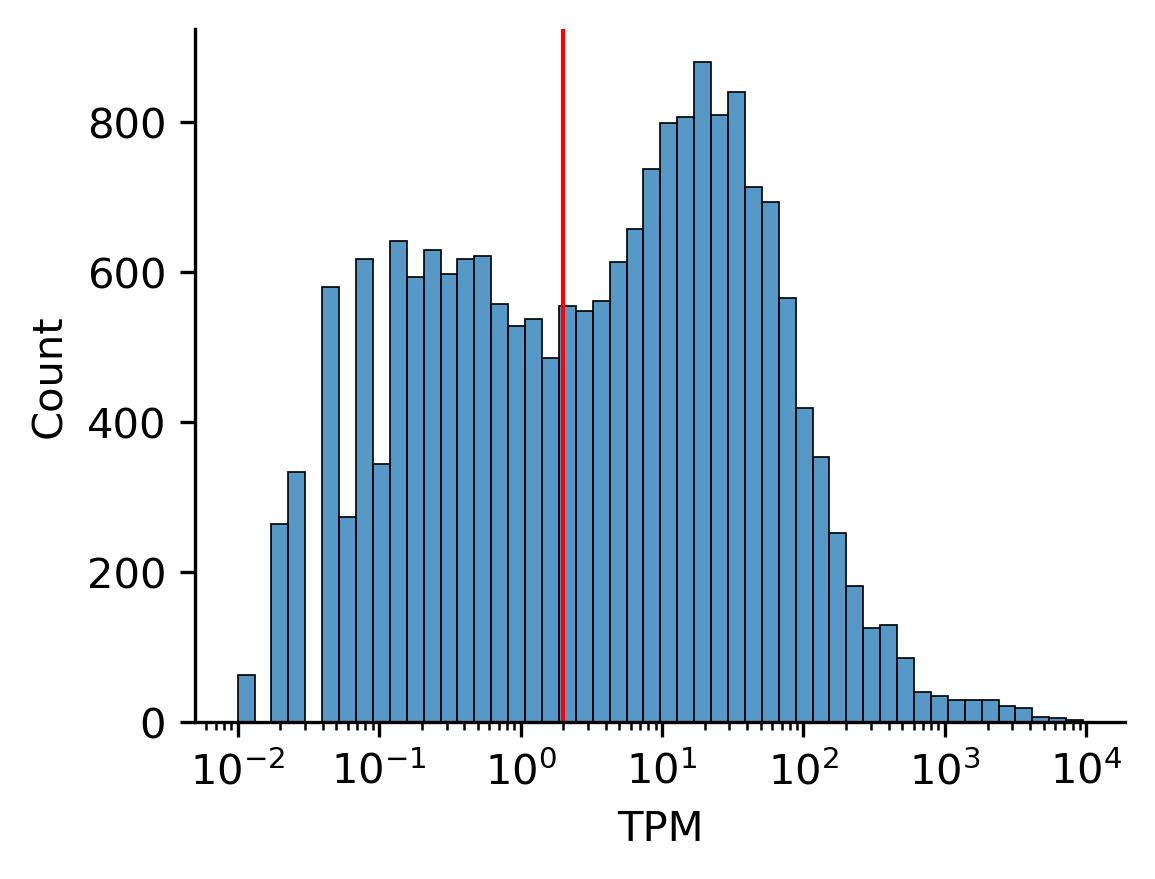

In [5]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4 ,3

sns.histplot(
    data=tdf[tdf['TPM'] > 0], 
    x='TPM',
    bins=50,
    log_scale=True,
)

plt.axvline(x=2.0, c='r', lw=1)
sns.despine()

# core vs expression

pdf.shape=(47686, 3)
is_core
False    32485
True     15201
Name: count, dtype: int64

is_core
False    0.681227
True     0.318773
Name: proportion, dtype: float64
T-statistic: 39.09
P-value: 0.000


,gene_name,is_core,expression
0,Ulk4,False,1.633154
1,Smarca2,False,1.713798
2,Dlgap3,True,4.487962
3,Gm56531,False,NaN
4,Twsg1,False,3.184698


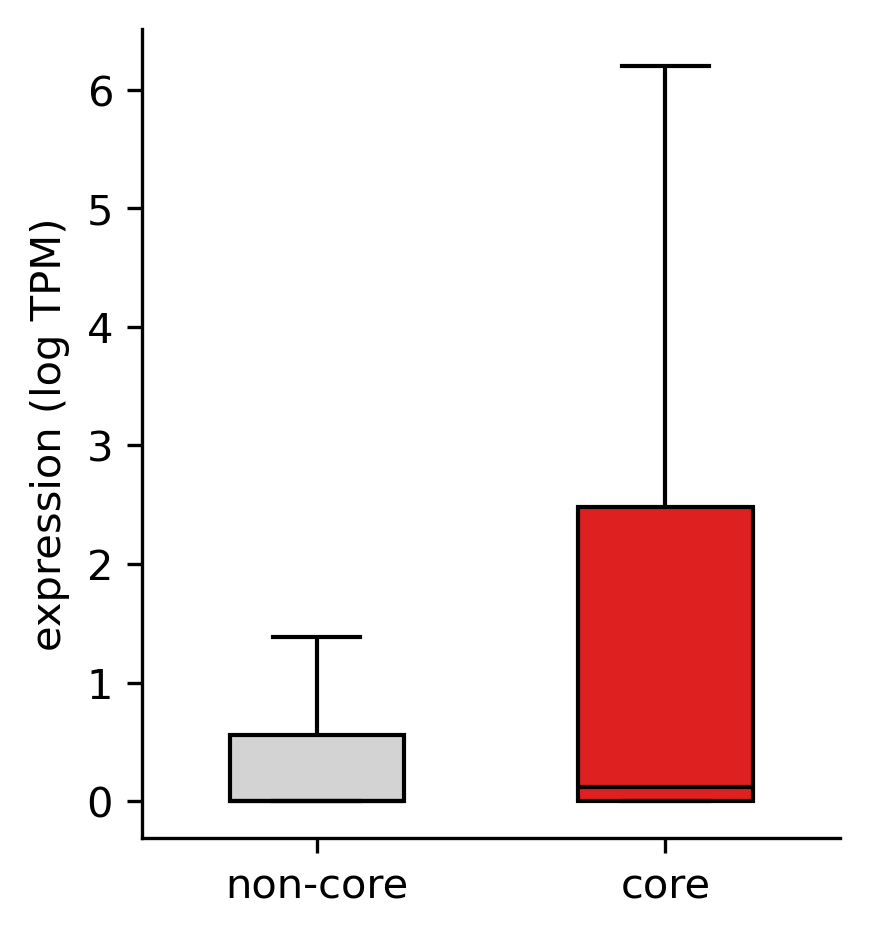

In [64]:
pdf = df.copy()

pdf = pdf[['gene_name', 'is_core', ]].drop_duplicates()
pdf['expression'] = np.log1p(pdf['gene_name'].map(expression_map))

print(f"{pdf.shape=}")
print(f"{pdf['is_core'].value_counts()}")
print()
print(f"{pdf['is_core'].value_counts(normalize=True)}")

# Perform t-test
core_expression = pdf[pdf['is_core'] == True]['expression'].fillna(0.0)
non_core_expression = pdf[pdf['is_core'] == False]['expression'].fillna(0.0)
t_stat, p_value = scipy.stats.ttest_ind(core_expression, non_core_expression)

print(f"T-statistic: {t_stat:.2f}")
print(f"P-value: {p_value:.3f}")

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 3.5

sns.boxplot(
    data=pdf,
    x='is_core',
    y='expression',
    hue='is_core',
    showfliers=False,
    palette=['lightgrey', 'red'],
    linecolor='k',
    width=0.5,
    legend=False,
)

plt.ylabel('expression (log TPM)')
plt.xlabel('')
plt.gca().set_xticklabels(['non-core', 'core'])

sns.despine()
pdf.head()

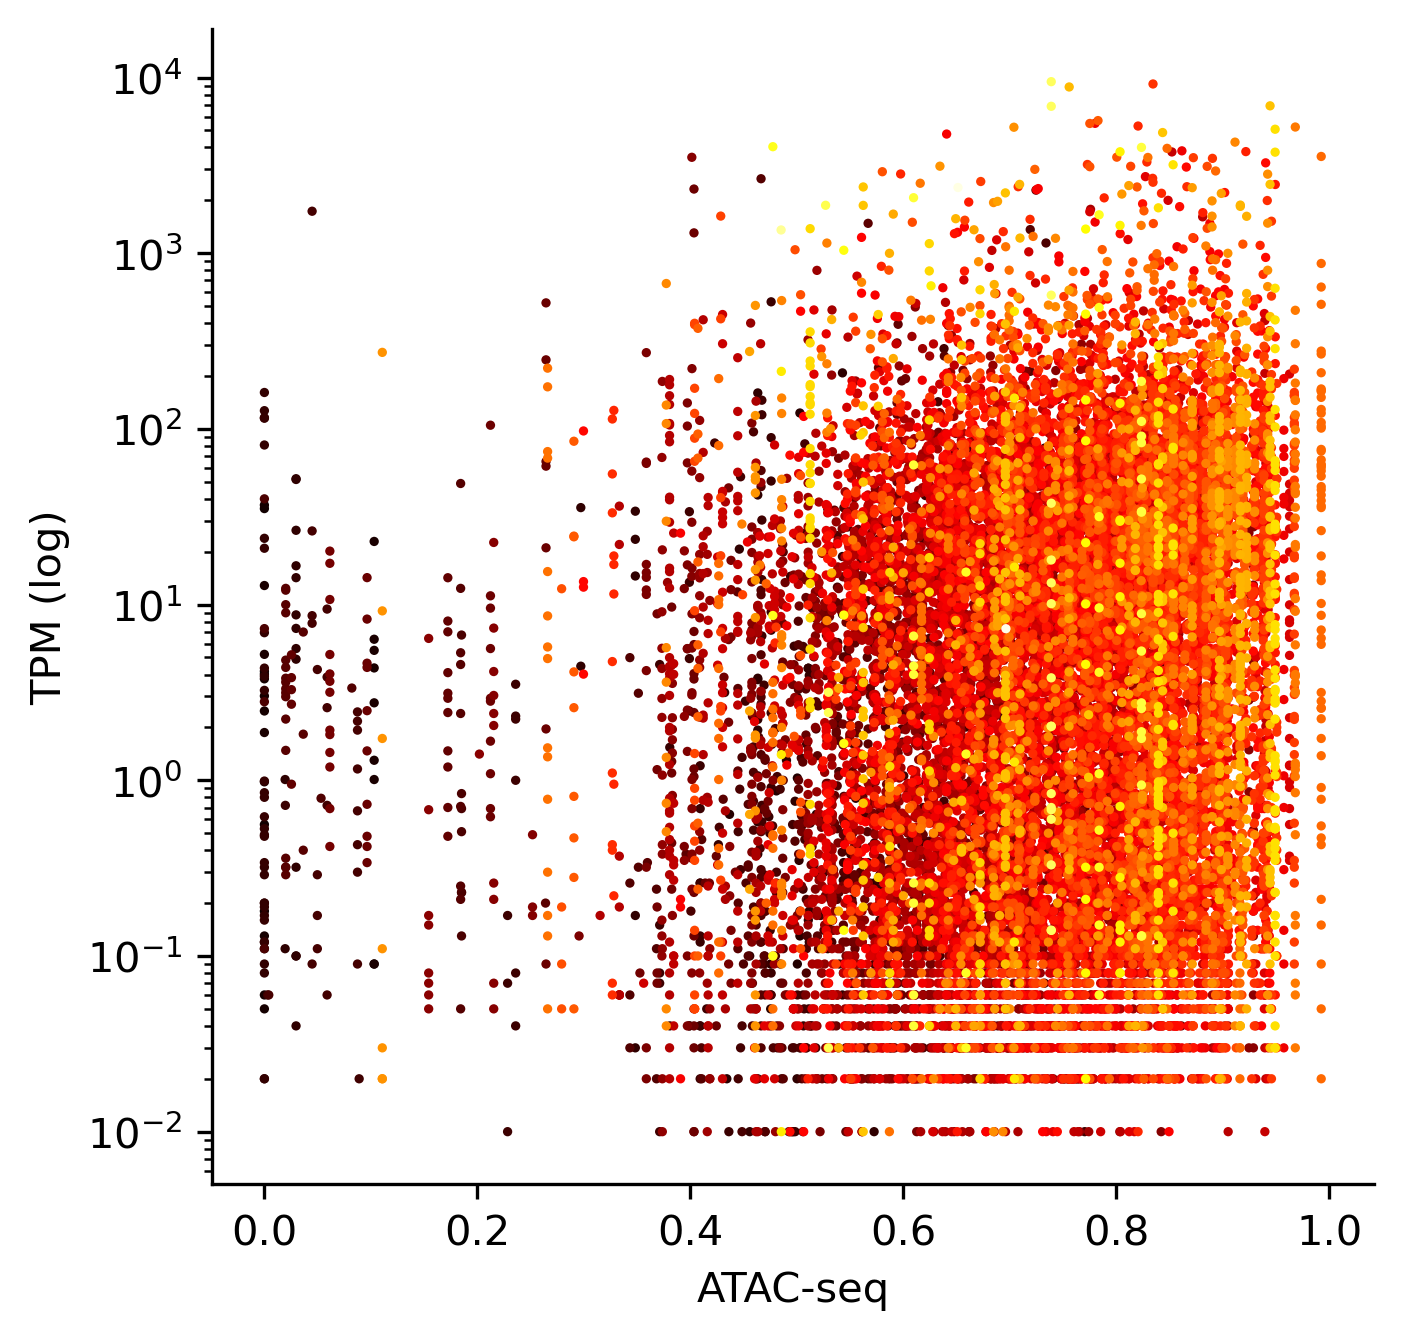

In [17]:
pdf = df.copy()

pdf = pdf[['gene_name', 'ATACSeq_1', 'CTCF', 'H3K27ac', 'is_core', 'global_hge_logexp_RNA_weighted']].drop_duplicates()
pdf['expression'] = pdf['gene_name'].map(expression_map)

pdf = pdf.sort_values(by='global_hge_logexp_RNA_weighted')

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 5

sns.scatterplot(
    data=pdf,
    x='ATACSeq_1',
    y='expression',
    ec='none',
    palette='hot',
    hue='global_hge_logexp_RNA_weighted',
    s=5,
    legend=False,
)

plt.yscale('log')

plt.ylabel('TPM (log)')
plt.xlabel('ATAC-seq')
sns.despine()

,gene_name,is_core,expression
0,Ulk4,False,1.633154
1,Smarca2,False,1.713798
2,Dlgap3,True,4.487962
3,Gm56531,False,NaN
4,Twsg1,False,3.184698


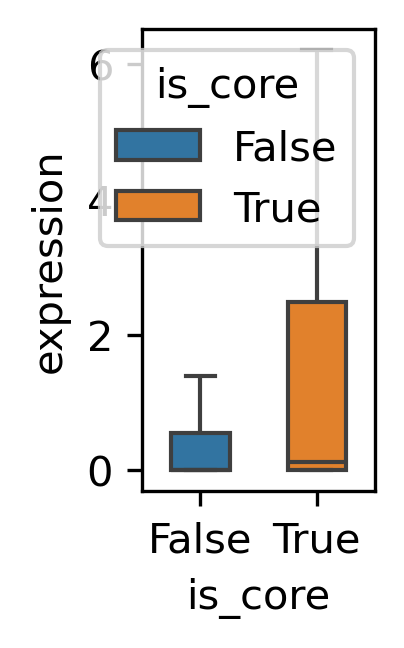

In [44]:
pdf = df.copy()

pdf = pdf[['gene_name', 'is_core', ]].drop_duplicates()
pdf['expression'] = np.log1p(pdf['gene_name'].map(expression_map))

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 1, 2

sns.boxplot(
    data=pdf,
    x='is_core',
    y='expression',
    hue='is_core',
    showfliers=False,
    width=0.5,
)

pdf.head()

<Axes: xlabel='ATACSeq_1', ylabel='expression'>

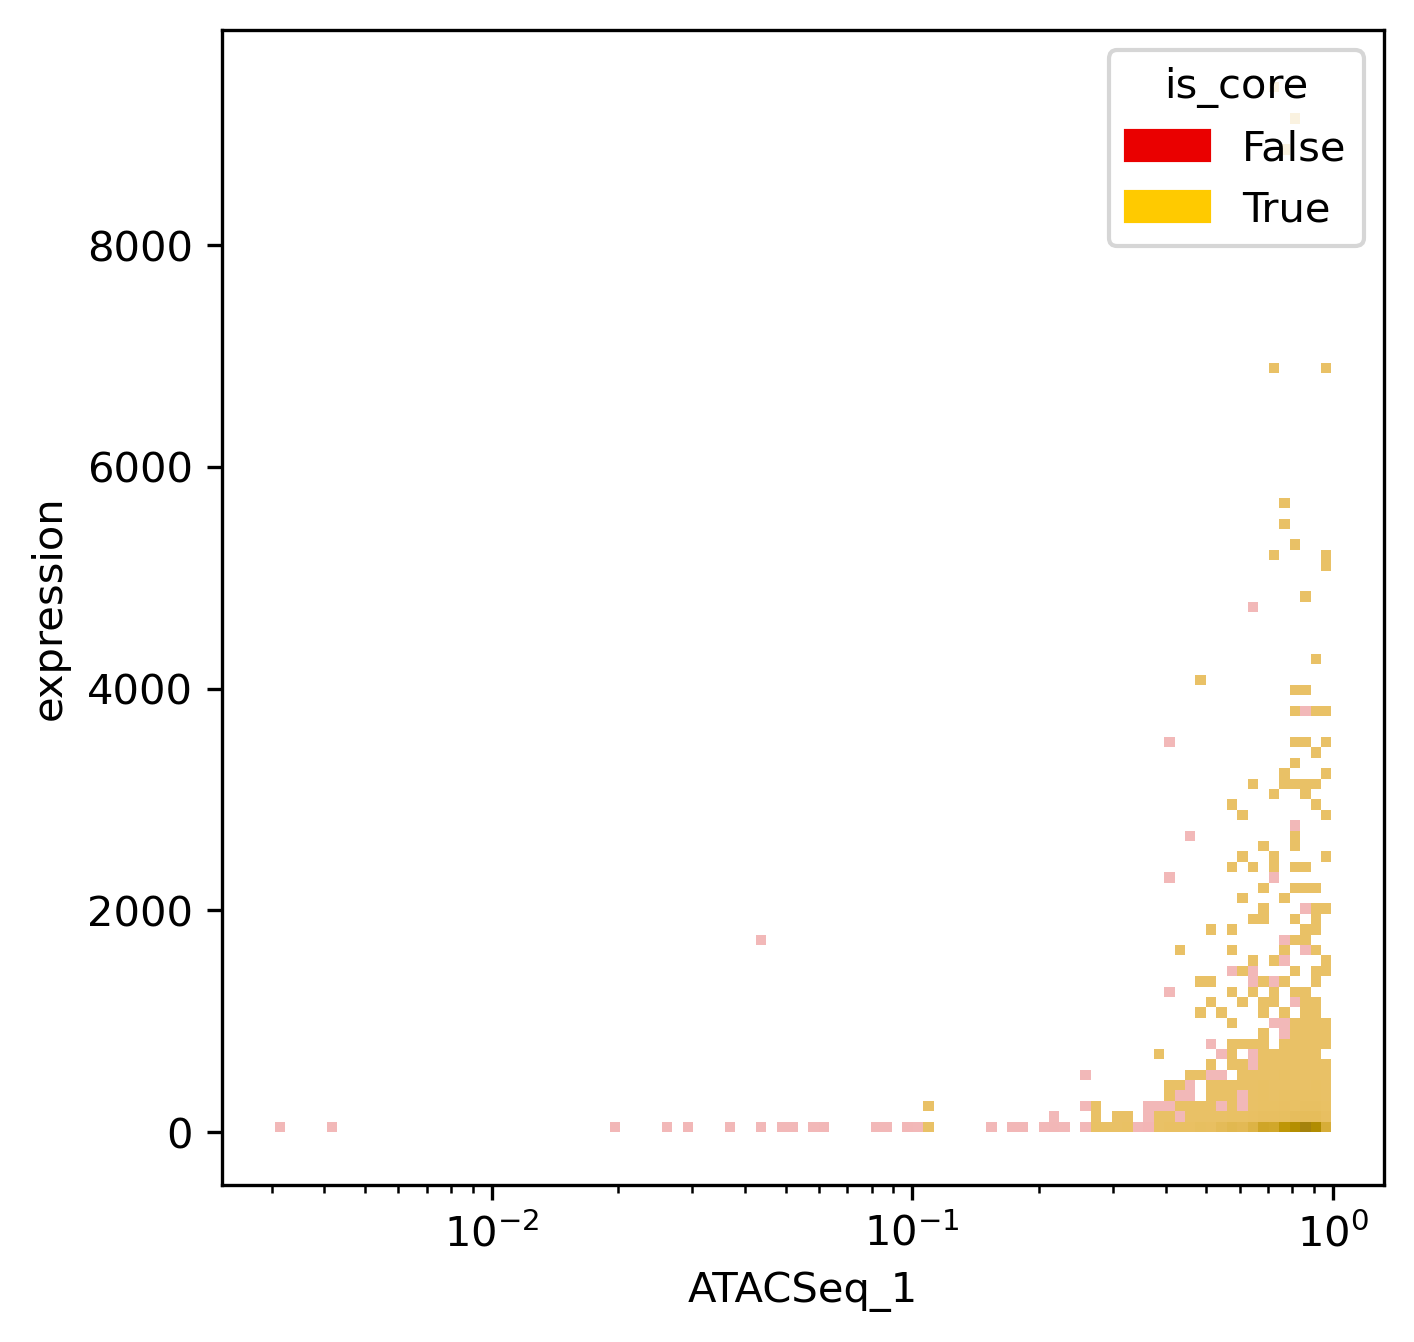

In [31]:
pdf = df.copy()

pdf = pdf[['gene_name', 'ATACSeq_1', 'CTCF', 'H3K27ac', 'is_core', 'global_hge_logexp_RNA_weighted']].drop_duplicates()
pdf['expression'] = pdf['gene_name'].map(expression_map)
pdf = pdf[pdf['expression'] > 0]
pdf = pdf[pdf['ATACSeq_1'] > 0]

pdf = pdf.sort_values(by='global_hge_logexp_RNA_weighted')

sns.histplot(
    data=pdf,
    kde=True,
    x='ATACSeq_1',
    y='expression',
    bins=101,
    log_scale=(True, False),
    palette='hot',
    hue='is_core',
)